<a href="https://colab.research.google.com/github/charoAI/charoAI.net/blob/main/FinalProject_CAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project – Option 1 (Guided Project)
**Due:** August 6, 2025 at 11:59 PM  
**Total Points:** 100  
This notebook provides the structure for the guided version of the final project. Complete all tasks as instructed (mostly marked as #TODO)

## Part 1: Reproducibility & Softmax (15 pts)
**Task:**
- Set random seeds for NumPy, Python, and TensorFlow to ensure reproducibility.
- Implement a numerically stable softmax and visualize outputs for given logits.

In [71]:
# Set seeds for reproducibility
import numpy as np
import tensorflow as tf
import random
import math

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

print(f"Seeds set to {seed}. Rerun training to verify reproducibility.")

Seeds set to 42. Rerun training to verify reproducibility.


In [72]:
# Implement softmax function
# TODO: complete the function below
# This was the softmax function from our earlier assignment but it only takes 1D
def softmax(x):
  x_shift = x - np.max(x)  # shift values for numerical stability
  exp_x = np.exp(x_shift)  # elementwise exponentiation
  return exp_x / np.sum(axis=0)  # normalize to probabilities

logits1 = np.array([1,2,3])
logits2 = np.array([1000,1001,1002])
print('Softmax logits1:', softmax(logits1))
print('Softmax logits2:', softmax(logits2))

# This version of the softmax function takes 1D or 2D inputs:
def softmax_V2(z):
  z=np.asarray(z)
  if z.ndim==1:
    z_shift=z - np.max(z)
    exp_z=np.exp(z_shift)
    return exp_z/np.sum(exp_z)
  elif z.ndim==2:
    z_shift=z - np.max(z, axis=1, keepdims=True)
    exp_z=np.exp(z_shift)
    return exp_z/np.sum(exp_z, axis=1, keepdims=True)
  else:
    raise ValueError("Input must be 1D or 2D")


Softmax logits1: [0.09003057 0.24472847 0.66524096]
Softmax logits2: [0.09003057 0.24472847 0.66524096]


In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 2: NumPy MLP from Scratch (20 pts)
**Task:**
- Implement a 2-layer MLP (linear→ReLU→linear→softmax) using NumPy.
- Train it on a toy dataset or MNIST subset.
- Plot training and validation accuracy curves.

In [74]:
# TODO: implement forward pass, loss, and backpropagation
# Provide skeletons for students to fill in
class SimpleMLP:
    def __init__(self, input_dim, hidden_dim, output_dim, lr=0.01):
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.01
        self.b2 = np.zeros((1, output_dim))
        self.lr = lr

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        # Convert sparse labels to one-hot encoding
        y_true_one_hot = np.zeros_like(y_pred)
        y_true_one_hot[np.arange(m), y_true] = 1
        # Clip values to avoid log(0)
        y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)
        loss = -np.sum(y_true_one_hot * np.log(y_pred)) / m
        return loss

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.relu(self.z1) # ReLU activation
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.softmax(self.z2) # softmax activation
        return self.a2

    def backward(self, X, y):
        m = X.shape[0]
        y_one_hot = np.zeros_like(self.a2)
        y_one_hot[np.arange(m), y] = 1
        dz2 = self.a2 - y_one_hot # dL/dz2 (softMax+CE)
        self.dW2 = (self.a1.T @ dz2) / m
        self.db2 = np.sum(dz2, axis=0, keepdims=True) / m
        # This is the hidden layer stuff
        da1 = dz2 @ self.W2.T
        dz1 = da1 * self.relu_derivative(self.z1)
        self.dW1 = (X.T @ dz1) / m
        self.db1 = np.sum(dz1, axis=0, keepdims=True) / m

    def update_params(self):
        self.W1 -= self.lr * self.dW1
        self.b1 -= self.lr * self.db1
        self.W2 -= self.lr * self.dW2
        self.b2 -= self.lr * self.db2


## Part 3: Keras MLP + Hyperparameter Sweep (20 pts)
**Task:**
- Build a 2-layer MLP with Keras.
- Sweep over hidden layer widths (64,128,256) and depths (1 vs 2 layers).
- Record validation accuracies and summarize results.

In [75]:
# TODO: implement keras model and hyperparameter sweep
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

# Converting sparse labels to one-hot encoding
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes=10)

def build_model(input_dim, hidden_dim, num_layers=1):
    model = Sequential()
    model.add(Dense(hidden_dim, activation='relu', input_shape=(input_dim,)))
    if num_layers > 1:
        model.add(Dense(hidden_dim, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

widths=[64, 128, 256]
depths=[1, 2]
epochs=20
batch_size=64

results=[]

for w in widths:
  for d in depths:
    print(f"Training with width={w}, depth={d}")
    model = build_model(input_dim=X_train.shape[1], hidden_dim=w, num_layers=d)
    history = model.fit(
        X_train, y_train_oh, # Use one-hot encoded labels
        validation_data=(X_val, y_val_oh), # Use one-hot encoded labels
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    val_acc = max(history.history["val_accuracy"])
    results.append({"width": w, "depth":d, "val_accuracy":float(val_acc)})
    print(f"Done: width={w}, depth={d}, best_val_acc={val_acc:.4f}")

results=sorted(results, key=lambda r:r["val_accuracy"], reverse=True)
print("\nAll runs (best first):")
for r in results:
  print(r)

best=results[0]
print("\nBest Configuration:", best)

Training with width=64, depth=1
Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6455 - loss: 1.2288 - val_accuracy: 0.8963 - val_loss: 0.3739
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9081 - loss: 0.3362 - val_accuracy: 0.9140 - val_loss: 0.3041
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9265 - loss: 0.2614 - val_accuracy: 0.9213 - val_loss: 0.2744
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9404 - loss: 0.2178 - val_accuracy: 0.9258 - val_loss: 0.2542
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9498 - loss: 0.1849 - val_accuracy: 0.9289 - val_loss: 0.2396
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9567 - loss: 0.1593 - val_accuracy: 0.9323 - val_loss: 0.2284
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9623 - loss: 0.1381 - val_accuracy: 0.9355 - val_loss: 0.2184
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9677 -

## Part 4: Optimizer Comparison & Gradient Clipping (15 pts)
**Task:**
- Train models with SGD, RMSprop, Adam.
- Implement gradient clipping for SGD.
- Compare validation curves.

Training with SGD
Training with RMSprop
Training with Adam
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1696 - loss: 2.2071 - val_accuracy: 0.5155 - val_loss: 1.8320
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6009 - loss: 1.6965 - val_accuracy: 0.7152 - val_loss: 1.3862
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7417 - loss: 1.2864 - val_accuracy: 0.7821 - val_loss: 1.0784
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7997 - loss: 1.0120 - val_accuracy: 0.8140 - val_loss: 0.8846
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8251 - loss: 0.8399 - val_accuracy: 0.8315 - val_loss: 0.7607


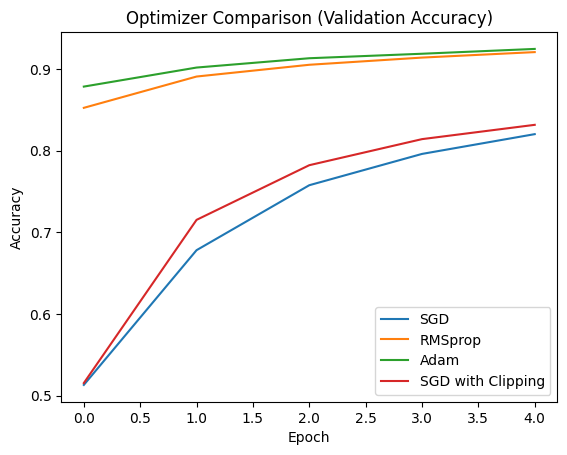

In [76]:
# TODO: train models with different optimizers and gradient clipping
# Define a helper to build and compile same architecture
def build_base_model():
    m = Sequential([
        Dense(64, activation='relu', input_shape=(784,)),
        Dense(10, activation='softmax')
    ])
    return m

# Convert sparse labels to one-hot encoding
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes=10)

# List of optimizers to compare
opts = {
    'SGD': tf.keras.optimizers.SGD(learning_rate=0.01),
    'RMSprop': tf.keras.optimizers.RMSprop(learning_rate=0.001),
    'Adam': tf.keras.optimizers.Adam(learning_rate=0.001)
}

histories = {}
for name, opt in opts.items():
    # Build model
    m = build_base_model()
    # Compile with chosen optimizer
    m.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    # Train briefly on subset for speed
    print(f"Training with {name}")
    hist = m.fit(X_train, y_train_oh, # Use one-hot encoded labels
                 validation_data=(X_val, y_val_oh), # Use one-hot encoded labels
                 epochs=5, batch_size=128, verbose=0)
    histories[name] = hist

# Build model with gradient clipping in optimizer
clip_model = build_base_model()
# SGD with gradient clipping by norm
opt_clip = tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.0)
clip_model.compile(optimizer=opt_clip,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Train with clipping
history_clip = clip_model.fit(
    X_train, y_train_oh, # Use one-hot encoded labels
    validation_data=(X_val, y_val_oh), # Use one-hot encoded labels
    epochs=5, batch_size=128, verbose=1
)

# Plot comparison of validation accuracy
import matplotlib.pyplot as plt

plt.figure()
for name, hist in histories.items():
    plt.plot(hist.history['val_accuracy'], label=name)
plt.plot(history_clip.history['val_accuracy'], label='SGD with Clipping') # Added plotting for clipping model
plt.title('Optimizer Comparison (Validation Accuracy)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

## Part 5: Deep-Sigmoid vs ReLU+BatchNorm (15 pts)
**Task:**
- Train a deep (8-layer) sigmoid network; log gradient norms.
- Retrain with ReLU, He init, BatchNorm; compare results.

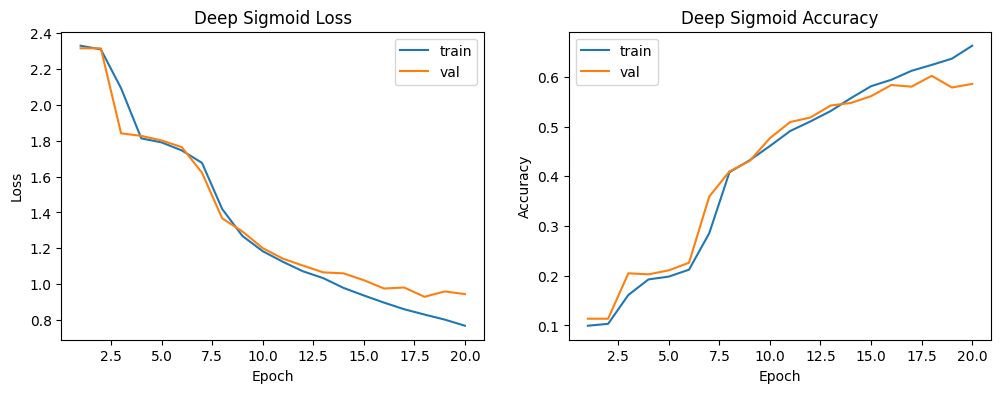

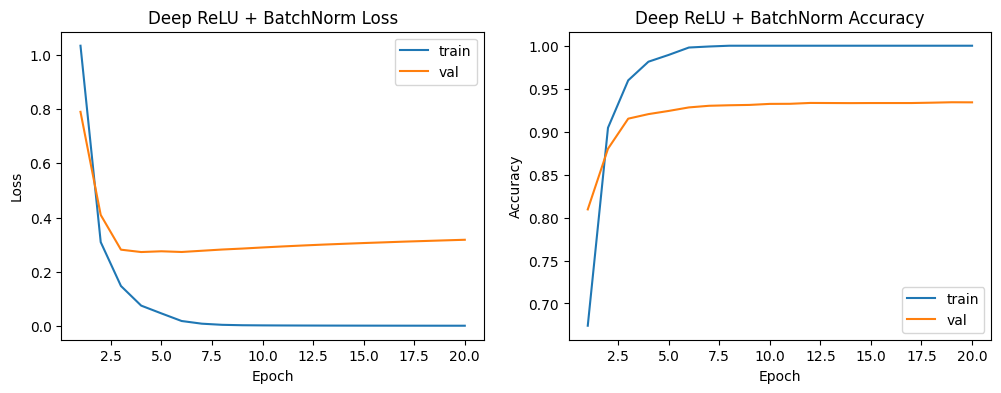

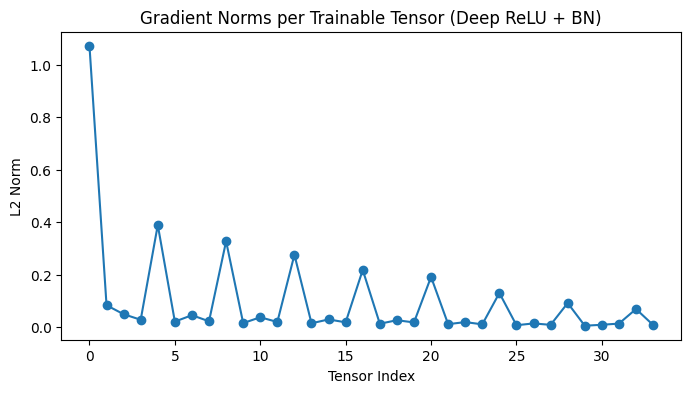

In [77]:
# TODO: build and train deep networks and log gradient norms
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam

# Convert sparse labels to one-hot encoding
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes=10)

width, depth = 128, 8

# Setting up the Deep Sigmoid
deep_sigmoid = Sequential()
deep_sigmoid.add(Dense(width, activation='sigmoid', input_shape=(784,)))
for _ in range(depth - 1):
    deep_sigmoid.add(Dense(width, activation='sigmoid'))
deep_sigmoid.add(Dense(10, activation='softmax'))

deep_sigmoid.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

hist_sigmoid = deep_sigmoid.fit(
    X_train, y_train_oh, # Using one-hot encoded labels
    validation_data=(X_val, y_val_oh), # Using one-hot encoded labels
    epochs=20, batch_size=128, verbose=0
)

# Setting up the ReLU, He Init, BatchNorm(bn)
deep_bn = Sequential()
deep_bn.add(Dense(width, activation='relu', kernel_initializer=HeNormal(), input_shape=(784,)))
deep_bn.add(BatchNormalization())
for _ in range(depth - 1):
    deep_bn.add(Dense(width, activation='relu', kernel_initializer=HeNormal()))
    deep_bn.add(BatchNormalization())
deep_bn.add(Dense(10, activation='softmax'))

deep_bn.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

hist_bn = deep_bn.fit(
    X_train, y_train_oh, # Using one-hot encoded labels
    validation_data=(X_val, y_val_oh), # Usign one-hot encoded labels
    epochs=20, batch_size=128, verbose=0
)

# Making the plots to compare the results
def plot_metrics(hist, title):
    epochs = range(1, len(hist.history['loss']) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist.history['loss'], label='train')
    plt.plot(epochs, hist.history['val_loss'], label='val')
    plt.title(f"{title} Loss"); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, hist.history['accuracy'], label='train')
    plt.plot(epochs, hist.history['val_accuracy'], label='val')
    plt.title(f"{title} Accuracy"); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
    plt.show()

plot_metrics(hist_sigmoid, "Deep Sigmoid")
plot_metrics(hist_bn, "Deep ReLU + BatchNorm")

# Making the graph for the gradient norm logging
x_batch, y_batch_oh = X_train[:256], y_train_oh[:256] # Use one-hot encoded labels for gradient calculation
with tf.GradientTape() as tape:
    preds = deep_bn(x_batch, training=True)
    # mean loss for the batch with one-hot encoded labels
    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch_oh, preds))

grads = tape.gradient(loss, deep_bn.trainable_weights)

norms = [tf.norm(g).numpy() for g in grads if g is not None]
plt.figure(figsize=(8,4))
plt.plot(norms, marker='o')
plt.title("Gradient Norms per Trainable Tensor (Deep ReLU + BN)")
plt.xlabel("Tensor Index"); plt.ylabel("L2 Norm")
plt.show()

## Part 6: Regularization & Diagnostics (15 pts)
**Task:**
- Add L2, dropout, and Gaussian noise.
- Train and plot weight histograms.
- Compare performance with/without regularization.

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.1066 - loss: 2.3482 - val_accuracy: 0.1260 - val_loss: 2.3077
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1071 - loss: 2.3111 - val_accuracy: 0.1260 - val_loss: 2.3086
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1069 - loss: 2.3101 - val_accuracy: 0.1260 - val_loss: 2.3078
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1180 - loss: 2.3060 - val_accuracy: 0.2190 - val_loss: 2.2126
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1939 - loss: 2.0704 - val_accuracy: 0.2190 - val_loss: 1.8392
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1935 - loss: 1.8226 - val_accuracy: 0.2240 - val_loss: 1.8196
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1956 - loss: 1.7931 - val_accuracy: 0.2260 - val_loss: 1.8037
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1935 - loss: 1.8048 - val_accuracy: 0.2240 - v

/usr/local/lib/python3.11/dist-packages/keras/src/layers/regularization/gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.0967 - loss: 2.5460 - val_accuracy: 0.1260 - val_loss: 2.3671
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1045 - loss: 2.4222 - val_accuracy: 0.1260 - val_loss: 2.3509
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1084 - loss: 2.4001 - val_accuracy: 0.1260 - val_loss: 2.3393
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1108 - loss: 2.3660 - val_accuracy: 0.0990 - val_loss: 2.3352
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1039 - loss: 2.3554 - val_accuracy: 0.0990 - val_loss: 2.3320
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1073 - loss: 2.3444 - val_accuracy: 0.0990 - val_loss: 2.3291
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1154 - loss: 2.3359 - val_accuracy: 0.0990 - val_loss: 2.3274
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1116 - loss: 2.3358 - val_accuracy: 0.0990 - v

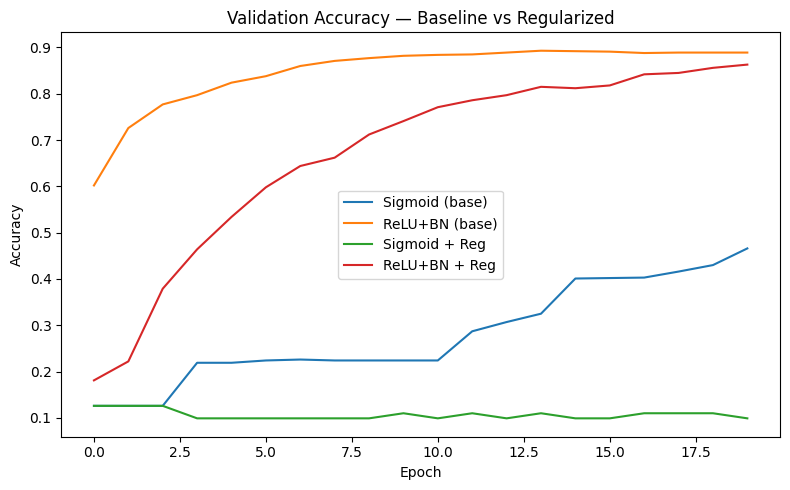

In [78]:
# TODO: add regularization layers and evaluate performance
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GaussianNoise
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# One-hot labels
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val_oh   = tf.keras.utils.to_categorical(y_val,   num_classes=10)

# Just to keep hyperparams consistent across all runs
width, depth     = 128, 8
weight_decay     = 1e-4
drop_p           = 0.3
noise_std        = 0.1
EPOCHS           = 20
BATCH_SIZE       = 128
TRAIN_SLICE      = slice(0, 5000)
VAL_SLICE        = slice(0, 1000)


# Deep Sigmoid (no BN, no regularization)
deep_sigmoid = Sequential()
deep_sigmoid.add(Dense(width, activation="sigmoid", input_shape=(784,)))
for _ in range(depth - 1):
    deep_sigmoid.add(Dense(width, activation="sigmoid"))
deep_sigmoid.add(Dense(10, activation="softmax"))
deep_sigmoid.compile(optimizer='adam',
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])

# Training Deep Sigmoid (baseline)
hist_sig_base = deep_sigmoid.fit(
    X_train[TRAIN_SLICE], y_train_oh[TRAIN_SLICE],
    validation_data=(X_val[VAL_SLICE], y_val_oh[VAL_SLICE]),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1
)

# Deep ReLU + BatchNorm (He init) (no regularization)
deep_relu_bn = Sequential()
deep_relu_bn.add(Dense(width, activation="relu", kernel_initializer=HeNormal(),
                       input_shape=(784,)))
deep_relu_bn.add(BatchNormalization())
for _ in range(depth - 1):
    deep_relu_bn.add(Dense(width, activation="relu", kernel_initializer=HeNormal()))
    deep_relu_bn.add(BatchNormalization())
deep_relu_bn.add(Dense(10, activation="softmax"))
deep_relu_bn.compile(optimizer='adam',
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])

# Training Deep ReLU+BN (baseline)
hist_relu_base = deep_relu_bn.fit(
    X_train[TRAIN_SLICE], y_train_oh[TRAIN_SLICE],
    validation_data=(X_val[VAL_SLICE], y_val_oh[VAL_SLICE]),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1
)


# Deep Sigmoid + Reg
reg_sigmoid = Sequential()
reg_sigmoid.add(GaussianNoise(noise_std, input_shape=(784,)))
reg_sigmoid.add(Dense(width, activation="sigmoid", kernel_regularizer=l2(weight_decay)))
for _ in range(depth - 1):
    reg_sigmoid.add(Dropout(drop_p))
    reg_sigmoid.add(Dense(width, activation="sigmoid", kernel_regularizer=l2(weight_decay)))
reg_sigmoid.add(Dropout(drop_p))
reg_sigmoid.add(Dense(10, activation="softmax"))
reg_sigmoid.compile(optimizer='adam',
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

# Training Deep Sigmoid + Reg (Noise + L2 + Dropout)
hist_sig_reg = reg_sigmoid.fit(
    X_train[TRAIN_SLICE], y_train_oh[TRAIN_SLICE],
    validation_data=(X_val[VAL_SLICE], y_val_oh[VAL_SLICE]),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1
)

# Deep ReLU + BN + Reg
reg_relu_bn = Sequential()
reg_relu_bn.add(GaussianNoise(noise_std, input_shape=(784,)))
reg_relu_bn.add(Dense(width, activation="relu", kernel_initializer=HeNormal(),
                      kernel_regularizer=l2(weight_decay)))
reg_relu_bn.add(BatchNormalization())
for _ in range(depth - 1):
    reg_relu_bn.add(Dropout(drop_p))
    reg_relu_bn.add(Dense(width, activation="relu", kernel_initializer=HeNormal(),
                          kernel_regularizer=l2(weight_decay)))
    reg_relu_bn.add(BatchNormalization())
reg_relu_bn.add(Dropout(drop_p))
reg_relu_bn.add(Dense(10, activation="softmax"))
reg_relu_bn.compile(optimizer='adam',
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

# Training Deep ReLU+BN + Reg (Noise + L2 + Dropout)
hist_relu_reg = reg_relu_bn.fit(
    X_train[TRAIN_SLICE], y_train_oh[TRAIN_SLICE],
    validation_data=(X_val[VAL_SLICE], y_val_oh[VAL_SLICE]),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1
)


# Validation metrics (same split used during fit)
def report(name, hist):
    best_val = max(hist.history["val_accuracy"])
    last_val = hist.history["val_accuracy"][-1]
    print(f"{name:24s}  last val acc: {last_val:.4f} | best val acc: {best_val:.4f}")

report("Deep Sigmoid (base)", hist_sig_base)
report("Deep ReLU+BN (base)", hist_relu_base)
report("Deep Sigmoid + Reg",  hist_sig_reg)
report("Deep ReLU+BN + Reg",  hist_relu_reg)

# Plotting validation accuracy curves for all four
plt.figure(figsize=(8,5))
plt.plot(hist_sig_base.history["val_accuracy"], label="Sigmoid (base)")
plt.plot(hist_relu_base.history["val_accuracy"], label="ReLU+BN (base)")
plt.plot(hist_sig_reg.history["val_accuracy"],  label="Sigmoid + Reg")
plt.plot(hist_relu_reg.history["val_accuracy"], label="ReLU+BN + Reg")
plt.title("Validation Accuracy — Baseline vs Regularized")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.tight_layout(); plt.show()

## ✅ Submission
- Rename this file to `FinalProject-<GroupName>.ipynb`.
- Ensure all code runs and outputs are visible.
- Submit the Colab link and your PDF report to Canvas by the deadline.